In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


In [2]:
plt.style.use('fivethirtyeight')

In [3]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [4]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

In [5]:
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

## S Learner

In [6]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6377
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 26
[LightGBM] [Info] Start training from score 1.494441


array([0.56632385])

In [7]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6377
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 26
[LightGBM] [Info] Start training from score 1.494441


### Feature Importance (method = `auto`)

In [8]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': stars         0.425304
 tiger         0.420015
 quixotic      0.071294
 merciful      0.038874
 fireman       0.036881
 playground    0.001489
 eight         0.000761
 touch         0.000485
 shelf         0.000446
 rain          0.000439
 wrap          0.000415
 change        0.000331
 rigid         0.000330
 damp          0.000304
 adhesive      0.000304
 nonchalant    0.000299
 cute          0.000291
 clammy        0.000278
 sweltering    0.000274
 future        0.000269
 dependent     0.000242
 barbarous     0.000238
 lethal        0.000171
 offer         0.000161
 lip           0.000105
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

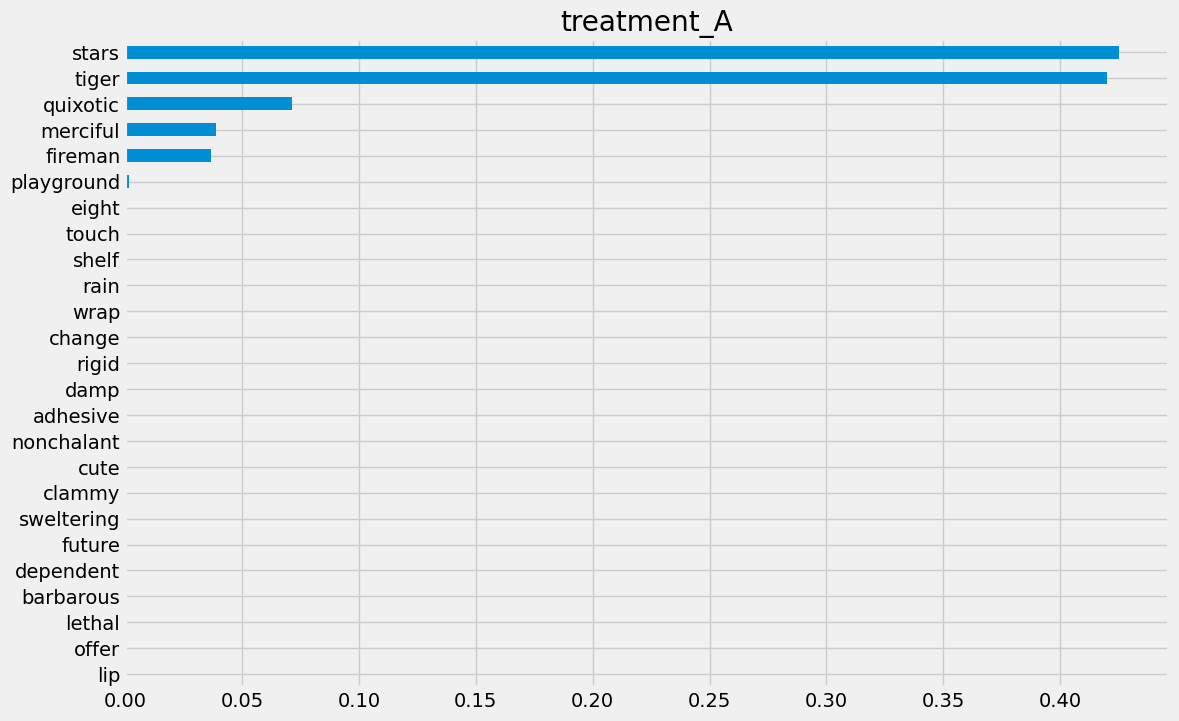

In [9]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [10]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': stars         0.944694
 tiger         0.889464
 quixotic      0.163027
 fireman       0.091862
 merciful      0.066448
 playground    0.001772
 eight         0.000783
 wrap          0.000234
 touch         0.000213
 rain          0.000154
 clammy        0.000144
 cute          0.000136
 offer         0.000120
 nonchalant    0.000108
 shelf         0.000089
 sweltering    0.000076
 rigid         0.000056
 barbarous     0.000056
 lethal        0.000050
 change        0.000046
 damp         -0.000004
 lip          -0.000019
 dependent    -0.000059
 future       -0.000089
 adhesive     -0.000209
 dtype: float64}

In [11]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

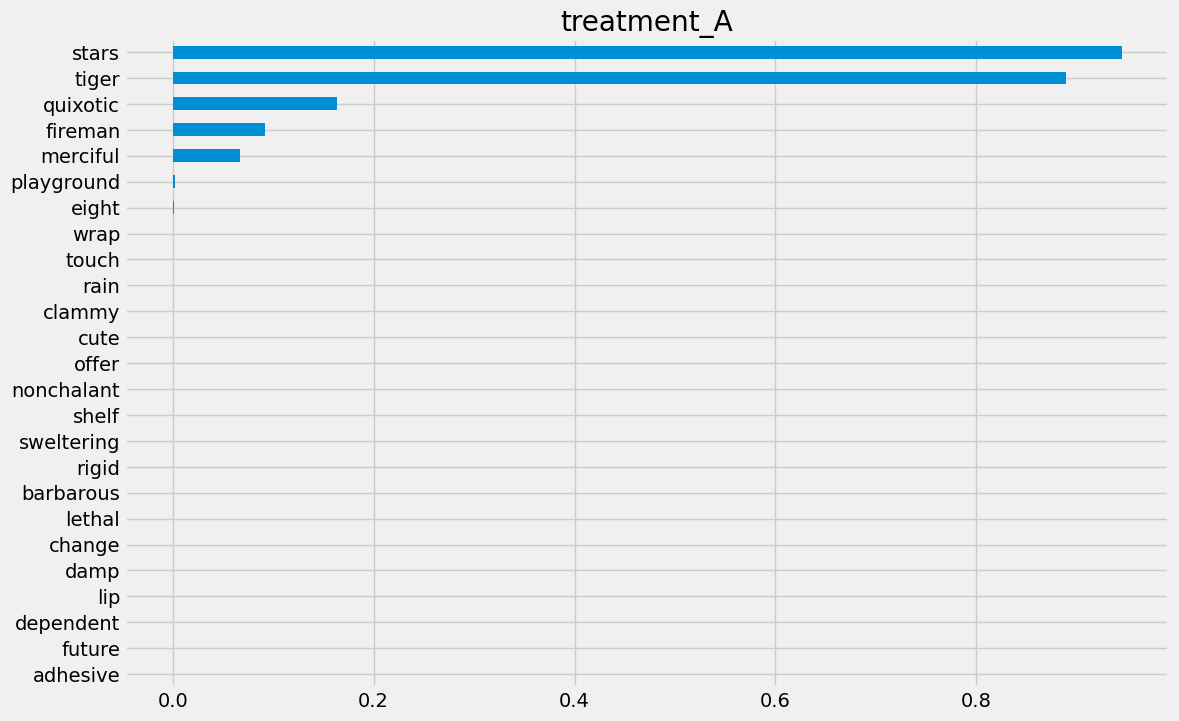

In [12]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [13]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 25
[LightGBM] [Info] Start training from score 0.566827
Elapsed time: 6.043889999389648 seconds


In [14]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

stars         0.944694
tiger         0.889464
quixotic      0.163027
fireman       0.091862
merciful      0.066448
playground    0.001772
eight         0.000783
wrap          0.000234
touch         0.000213
rain          0.000154
clammy        0.000144
cute          0.000136
offer         0.000120
nonchalant    0.000108
shelf         0.000089
sweltering    0.000076
rigid         0.000056
barbarous     0.000056
lethal        0.000050
change        0.000046
damp         -0.000004
lip          -0.000019
dependent    -0.000059
future       -0.000089
adhesive     -0.000209
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

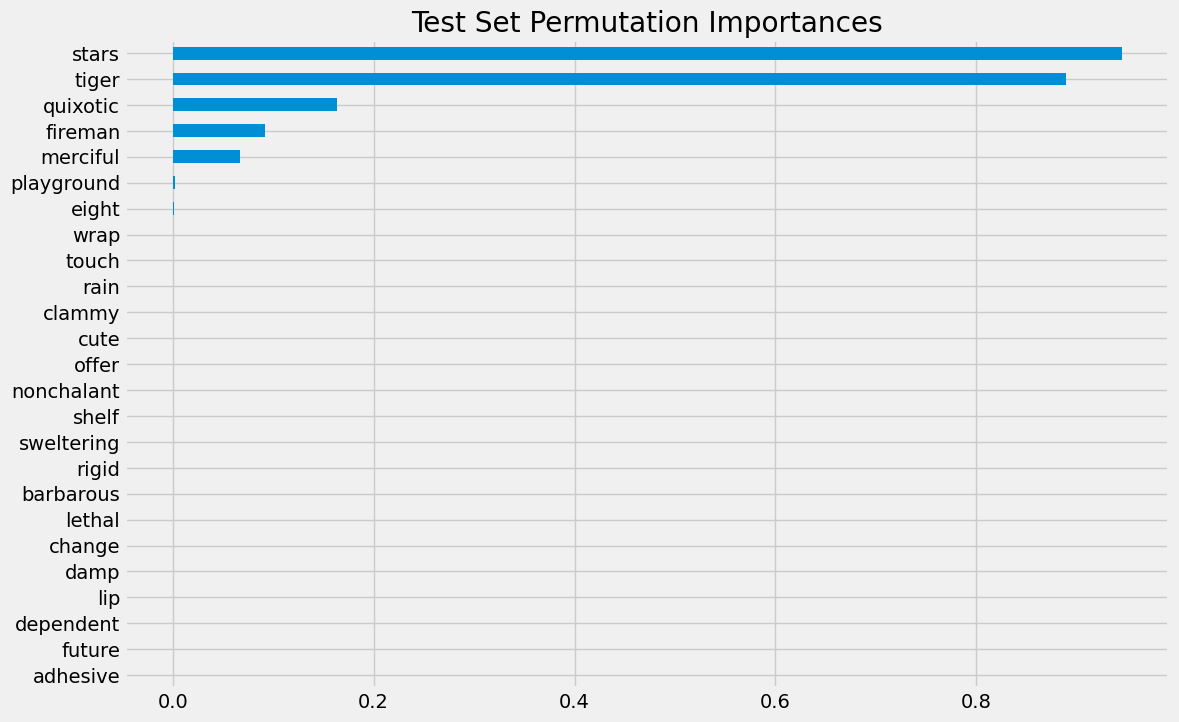

In [15]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [16]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

stars         0.933666
tiger         0.904716
quixotic      0.165290
fireman       0.097778
merciful      0.072289
playground    0.003815
eight         0.002912
adhesive      0.001791
touch         0.001762
nonchalant    0.001727
clammy        0.001435
wrap          0.001382
rain          0.001227
future        0.001047
barbarous     0.001009
offer         0.000933
cute          0.000902
damp          0.000811
shelf         0.000733
change        0.000726
lip           0.000665
dependent     0.000645
rigid         0.000628
sweltering    0.000620
lethal        0.000497
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

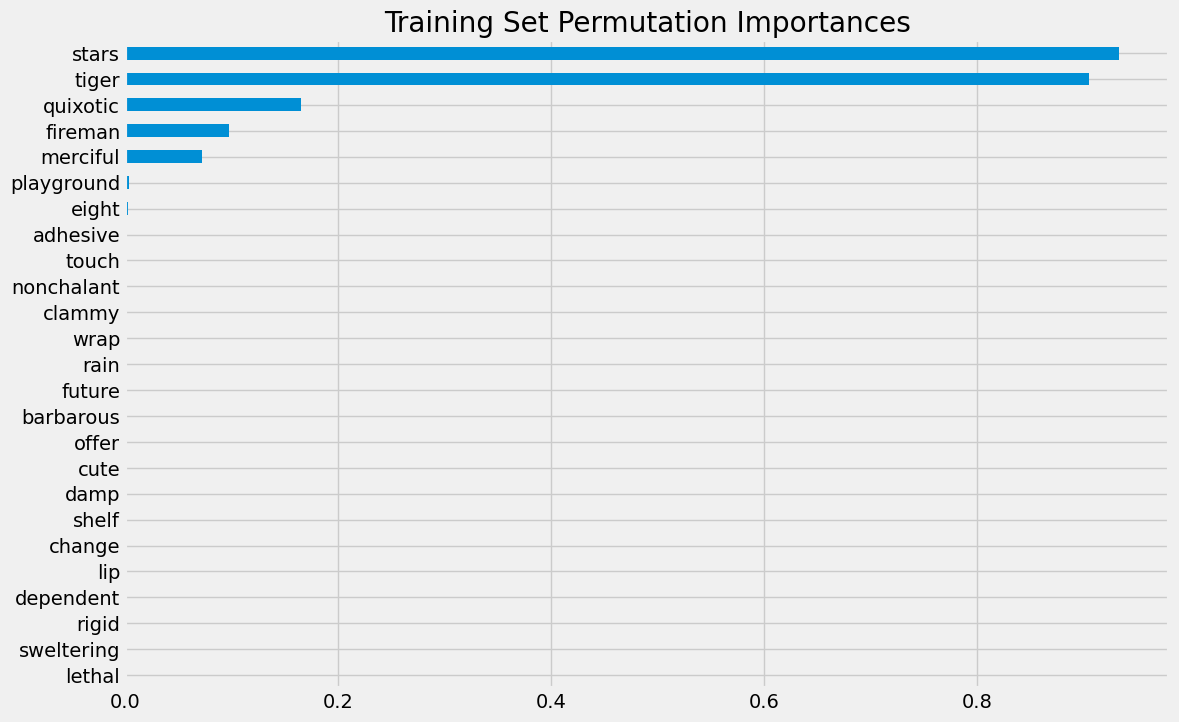

In [17]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [18]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': array([[ 8.56354568e-02,  6.53187320e-02, -9.25774057e-03, ...,
         -2.08084643e-05, -4.62793756e-04,  5.79639475e-05],
        [-5.83207333e-02,  1.16441251e-01,  1.52914429e-03, ...,
          1.89365350e-04,  3.21586327e-04, -2.87732381e-04],
        [-2.08427336e-01, -1.64237969e-01,  1.36478696e-02, ...,
         -6.00089393e-06,  1.72577556e-04,  9.00526957e-05],
        ...,
        [-2.19865844e-01, -1.53080702e-01, -5.18780726e-03, ...,
         -7.79264384e-05,  5.06568846e-04,  5.30760641e-05],
        [ 1.31329329e-01, -2.46039428e-01,  2.59066799e-03, ...,
          1.55866411e-04,  7.16730358e-05,  3.56622660e-04],
        [ 1.11574175e-01,  2.10027911e-01, -4.53415690e-02, ...,
          3.25123016e-04, -1.17951329e-04, -1.67763348e-05]])}

In [19]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.1353241 , 0.13228464, 0.02013351, 0.0303567 , 0.02667579,
       0.00030023, 0.0005842 , 0.00137705, 0.00129062, 0.00050701,
       0.00495936, 0.00106785, 0.00044434, 0.00084088, 0.0003629 ,
       0.00058884, 0.00052021, 0.00067032, 0.00033848, 0.00040588,
       0.00309014, 0.0008182 , 0.00027779, 0.00077335, 0.0001505 ])

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

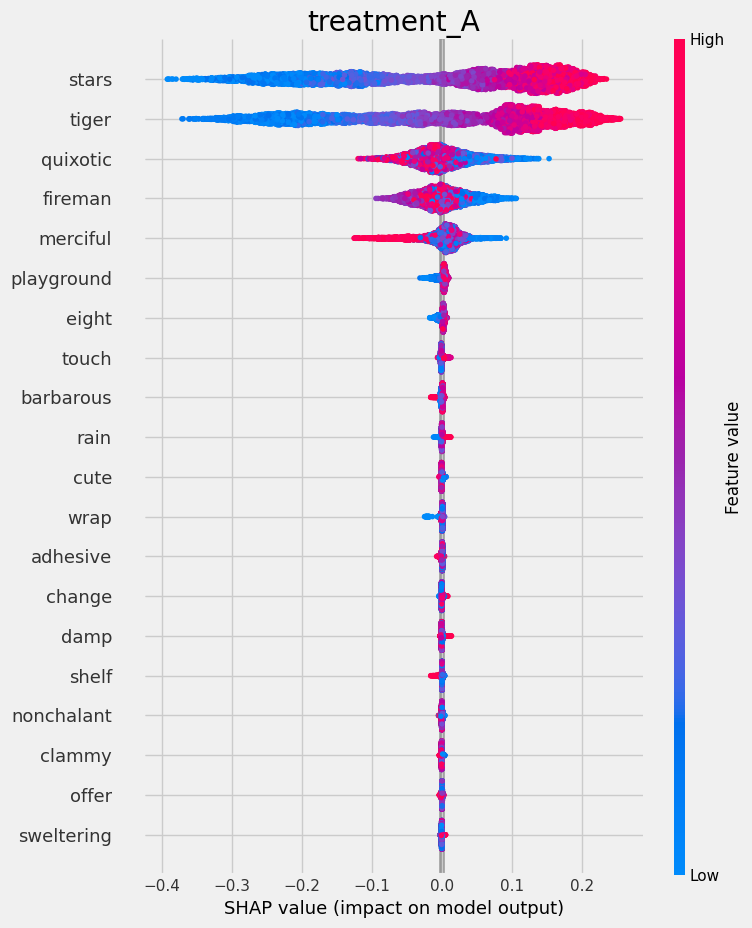

In [20]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

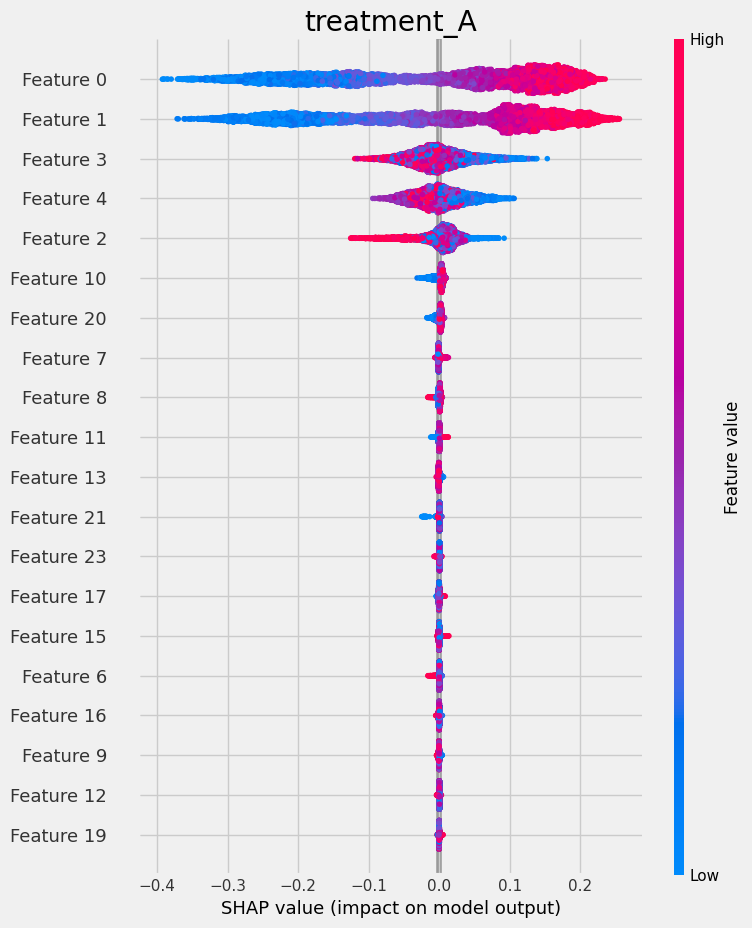

In [21]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

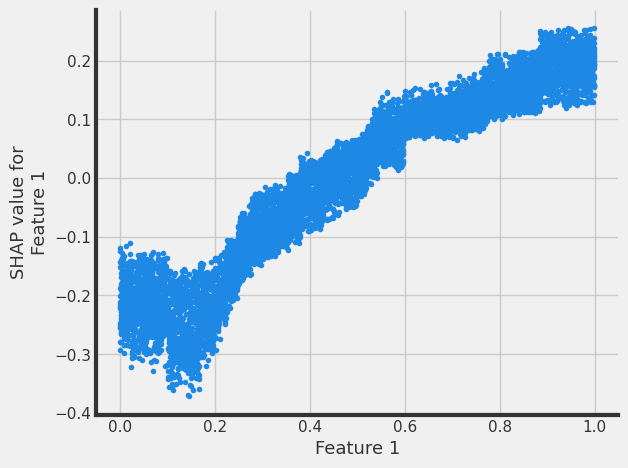

In [22]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

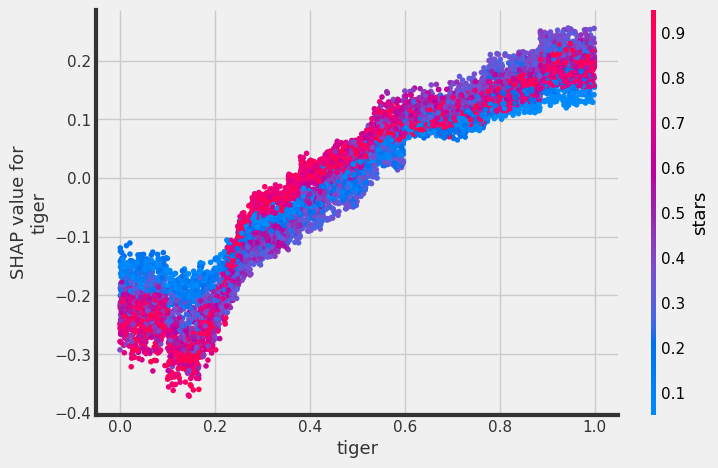

In [23]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

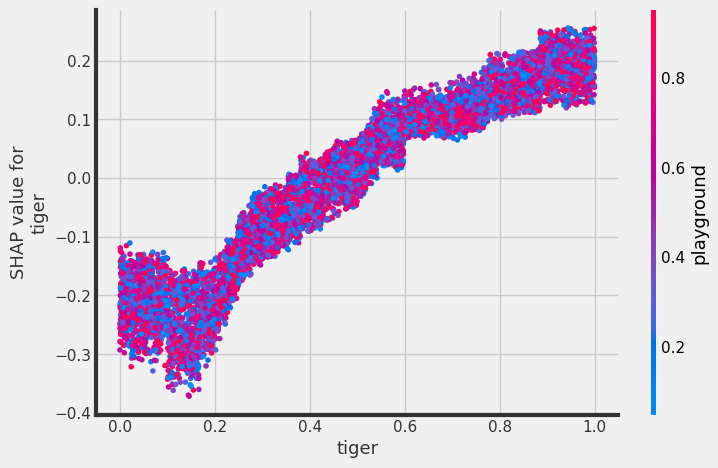

In [24]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

## T Learner

In [25]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 4814, number of used features: 25
[LightGBM] [Info] Start training from score 1.023221
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 5186, number of used features: 25
[LightGBM] [Info] Start training from score 1.931860


(array([0.56303606]), array([0.54844186]), array([0.57763026]))

In [26]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 4814, number of used features: 25
[LightGBM] [Info] Start training from score 1.023221
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 5186, number of used features: 25
[LightGBM] [Info] Start training from score 1.931860


### Feature Importance (method = `auto`)

In [27]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': tiger         0.337219
 stars         0.324740
 quixotic      0.045470
 merciful      0.040174
 fireman       0.027175
 touch         0.016545
 cute          0.015559
 eight         0.015038
 playground    0.014349
 shelf         0.013738
 sweltering    0.013162
 dependent     0.012852
 adhesive      0.011878
 future        0.011766
 barbarous     0.011717
 nonchalant    0.010970
 damp          0.010682
 change        0.010589
 offer         0.010323
 rigid         0.008761
 lip           0.008436
 lethal        0.008422
 rain          0.007540
 wrap          0.006468
 clammy        0.006427
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

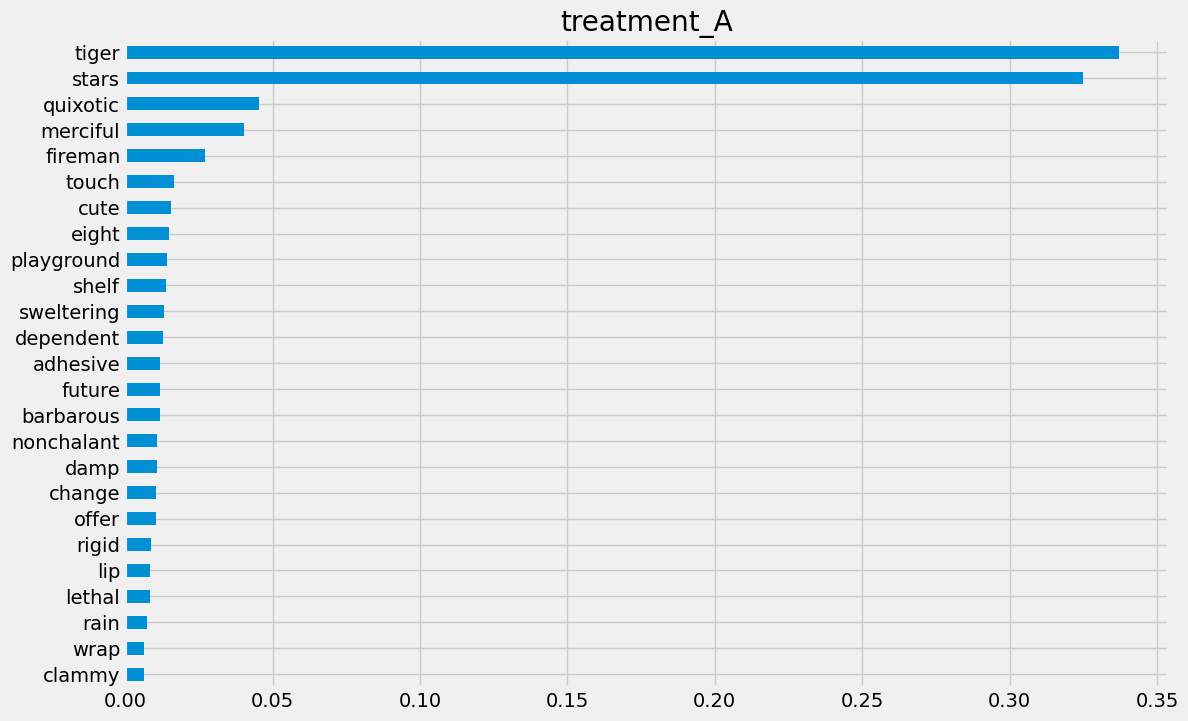

In [28]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [29]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': tiger         0.523691
 stars         0.511409
 quixotic      0.055765
 merciful      0.028724
 fireman       0.027674
 playground    0.011500
 eight         0.011335
 cute          0.009705
 touch         0.009317
 dependent     0.009254
 shelf         0.008745
 barbarous     0.006895
 adhesive      0.006447
 sweltering    0.006166
 damp          0.005840
 change        0.005147
 future        0.004634
 nonchalant    0.004560
 lip           0.004137
 offer         0.004100
 lethal        0.003303
 rigid         0.003132
 rain          0.002565
 wrap          0.001903
 clammy        0.001423
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

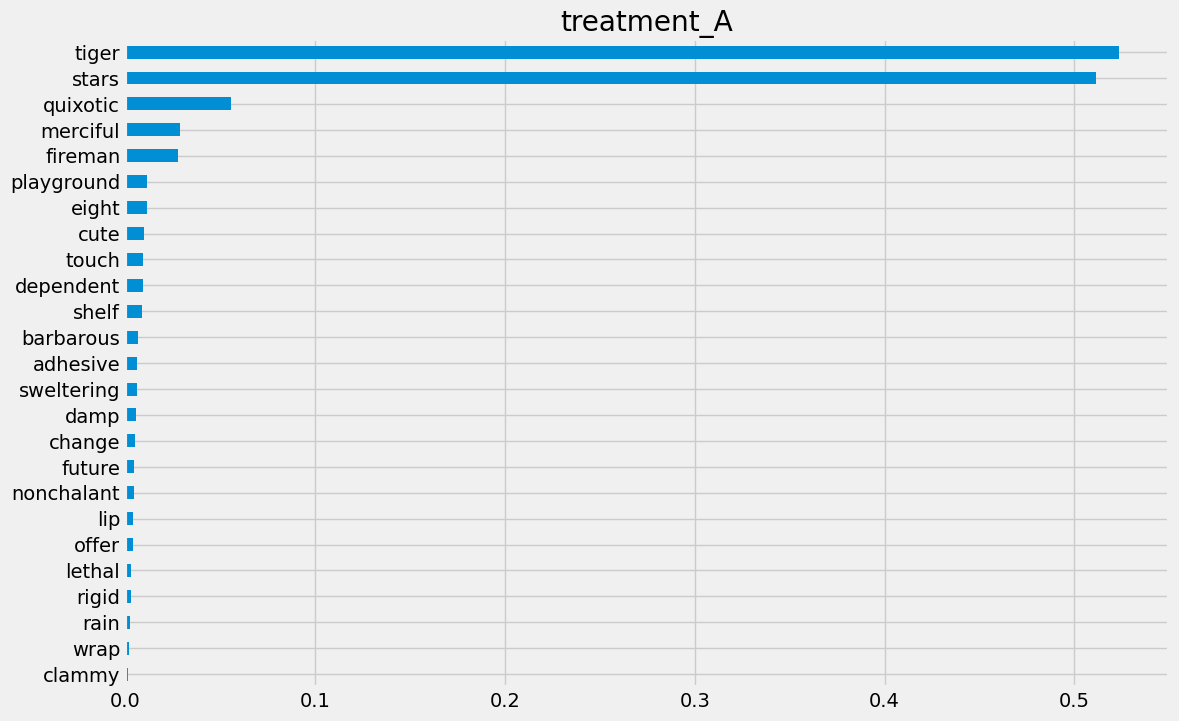

In [30]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [31]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 25
[LightGBM] [Info] Start training from score 0.563659
Elapsed time: 6.624058961868286 seconds


In [32]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.523691
stars         0.511409
quixotic      0.055765
merciful      0.028724
fireman       0.027674
playground    0.011500
eight         0.011335
cute          0.009705
touch         0.009317
dependent     0.009254
shelf         0.008745
barbarous     0.006895
adhesive      0.006447
sweltering    0.006166
damp          0.005840
change        0.005147
future        0.004634
nonchalant    0.004560
lip           0.004137
offer         0.004100
lethal        0.003303
rigid         0.003132
rain          0.002565
wrap          0.001903
clammy        0.001423
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

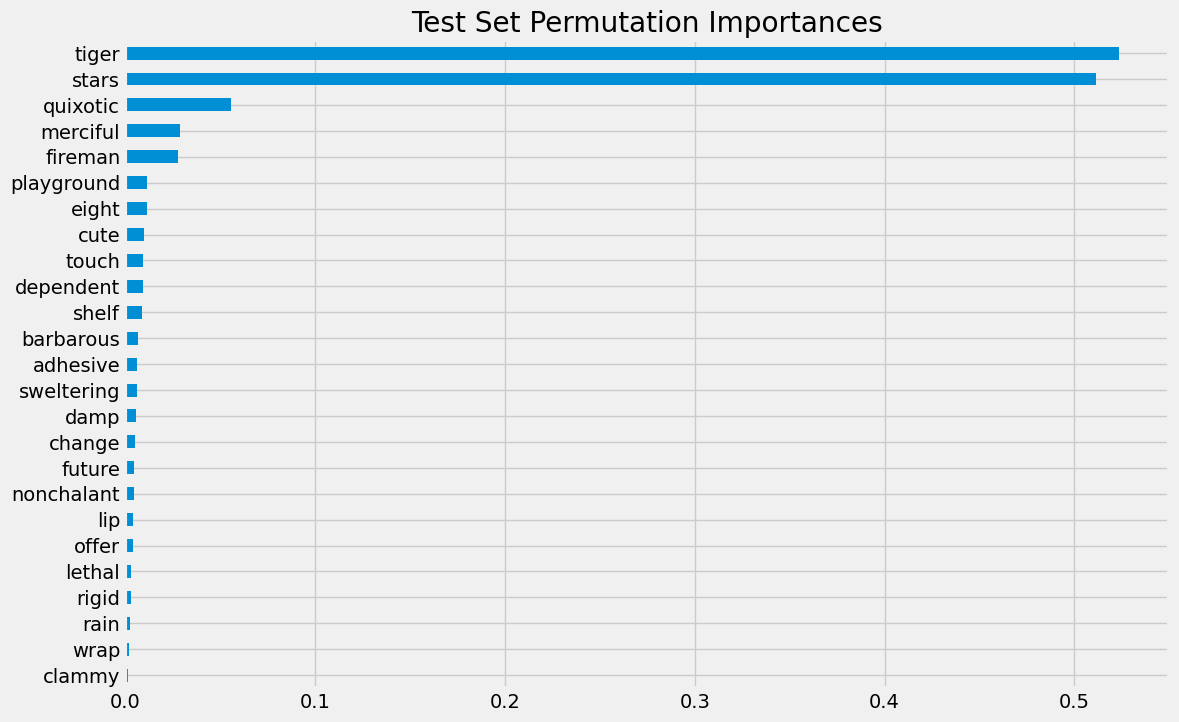

In [33]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [34]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': array([[ 0.05652058,  0.07445225,  0.00807581, ..., -0.00135981,
          0.00379829, -0.00545395],
        [-0.06538325,  0.10909456, -0.00200061, ..., -0.00639409,
          0.00855689,  0.03500229],
        [-0.17303124, -0.10744406,  0.01412305, ...,  0.01479146,
          0.00963712, -0.00392737],
        ...,
        [-0.2307688 , -0.21880474, -0.00363364, ...,  0.00953626,
          0.00372726, -0.00390723],
        [ 0.12633489, -0.31624384, -0.00713584, ...,  0.00630566,
          0.00824692,  0.02131503],
        [ 0.08353444,  0.28388425, -0.02093905, ..., -0.00492742,
          0.00489524, -0.00365225]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

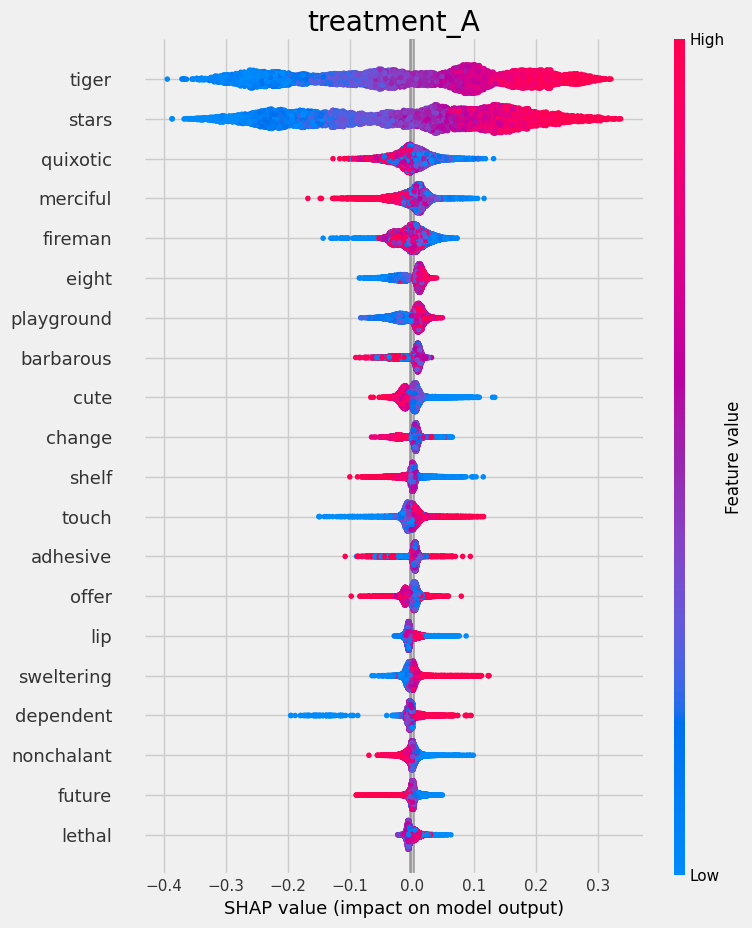

In [35]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

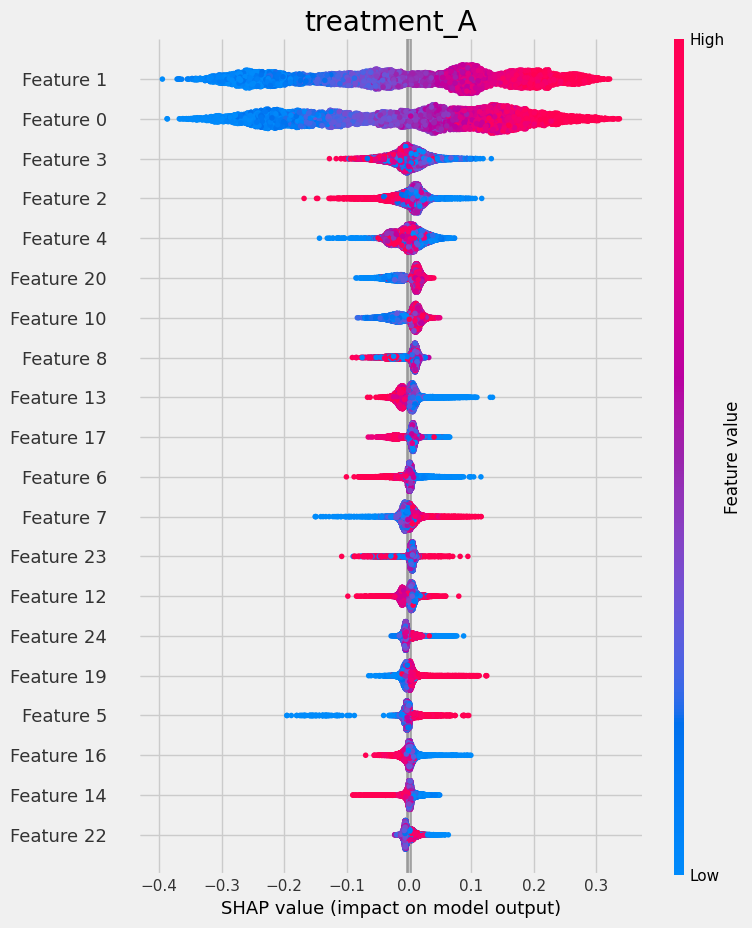

In [36]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(X=X, shap_dict=shap_tlearner)

## X Learner

In [37]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y, p=e_multi)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 4814, number of used features: 25
[LightGBM] [Info] Start training from score 1.023221
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 5186, number of used features: 25
[LightGBM] [Info] Start training from score 1.931860
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

(array([0.513159]), array([0.49940667]), array([0.52691134]))

In [38]:
xlearner_tau = xlearner.predict(X, w_multi, y, p=e_multi)

### Feature Importance (method = `auto`)

In [39]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': tiger         0.416977
 stars         0.381487
 cute          0.016434
 adhesive      0.015706
 merciful      0.014901
 dependent     0.013473
 lethal        0.010962
 touch         0.010800
 eight         0.010654
 shelf         0.010648
 change        0.009852
 offer         0.009729
 barbarous     0.009147
 damp          0.007769
 future        0.007755
 nonchalant    0.007557
 sweltering    0.006542
 rain          0.006433
 lip           0.006136
 playground    0.006022
 fireman       0.005939
 quixotic      0.005358
 clammy        0.003661
 rigid         0.003155
 wrap          0.002902
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

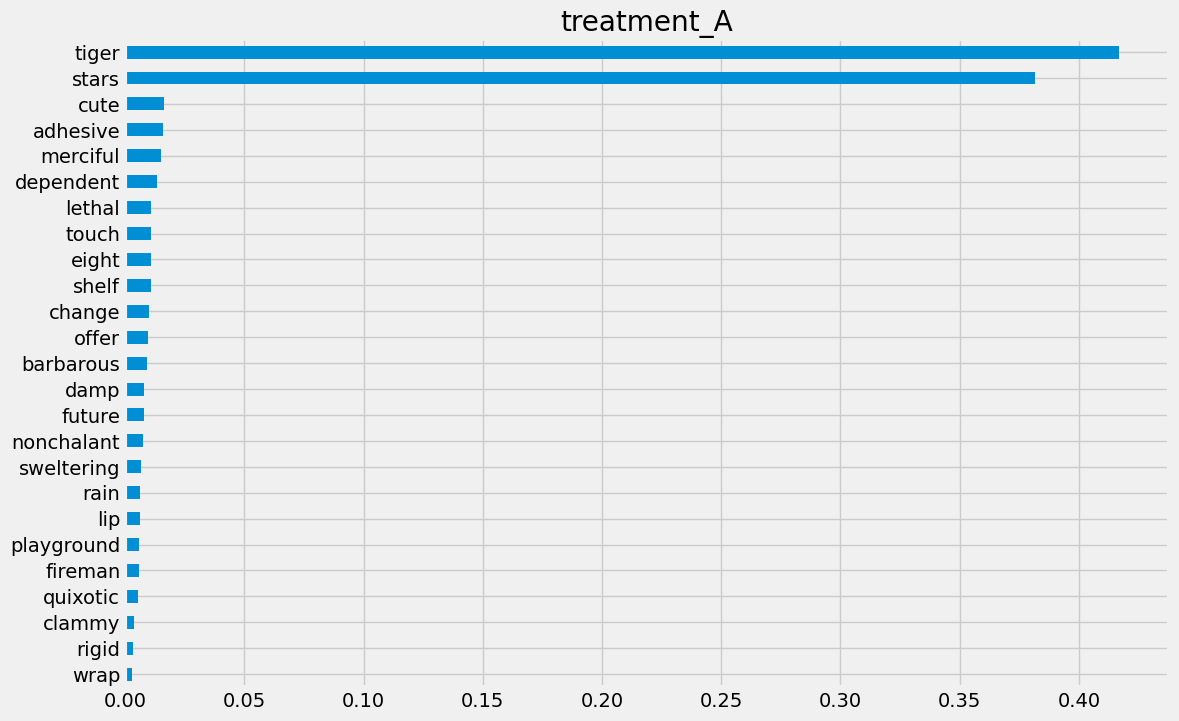

In [40]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [41]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': tiger         0.753883
 stars         0.697964
 cute          0.017684
 adhesive      0.015889
 dependent     0.014690
 merciful      0.014321
 lethal        0.013136
 change        0.011977
 eight         0.011468
 shelf         0.010182
 offer         0.008134
 barbarous     0.007949
 damp          0.007032
 touch         0.006781
 nonchalant    0.006460
 future        0.006103
 playground    0.005927
 sweltering    0.005124
 lip           0.004890
 fireman       0.004765
 quixotic      0.004642
 rain          0.004087
 rigid         0.001922
 clammy        0.001847
 wrap          0.001018
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

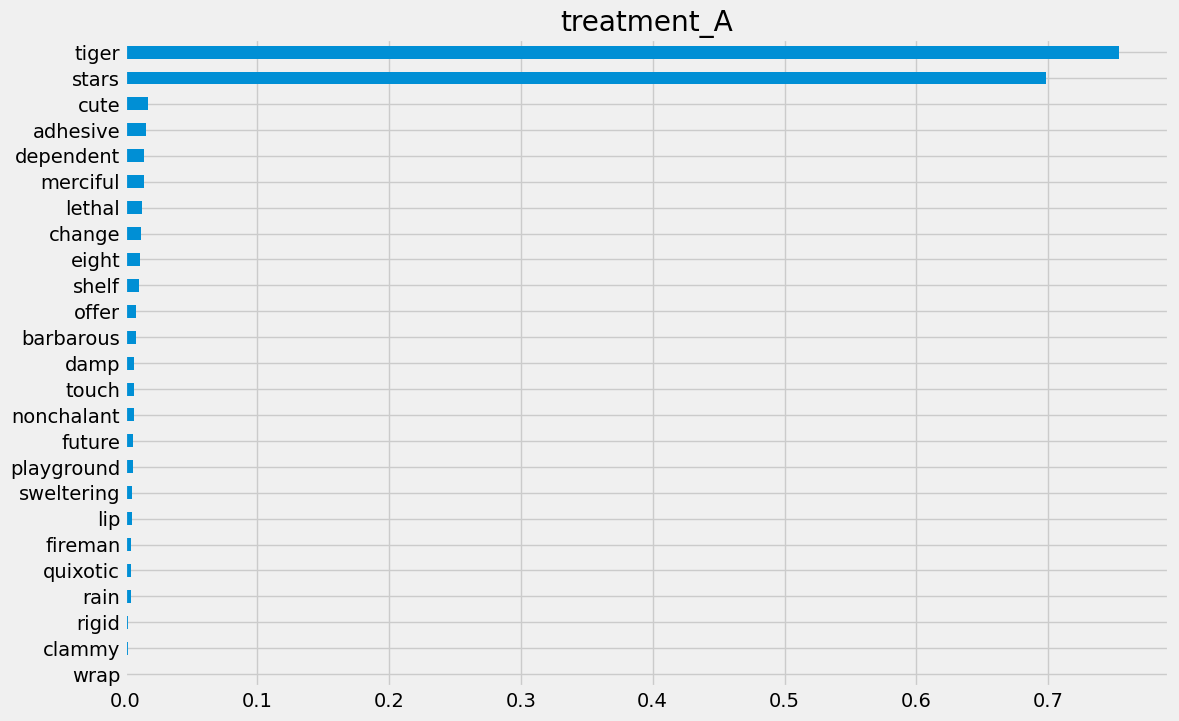

In [42]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [43]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 25
[LightGBM] [Info] Start training from score 0.512572
Elapsed time: 7.801329135894775 seconds


In [44]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.753883
stars         0.697964
cute          0.017684
adhesive      0.015889
dependent     0.014690
merciful      0.014321
lethal        0.013136
change        0.011977
eight         0.011468
shelf         0.010182
offer         0.008134
barbarous     0.007949
damp          0.007032
touch         0.006781
nonchalant    0.006460
future        0.006103
playground    0.005927
sweltering    0.005124
lip           0.004890
fireman       0.004765
quixotic      0.004642
rain          0.004087
rigid         0.001922
clammy        0.001847
wrap          0.001018
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

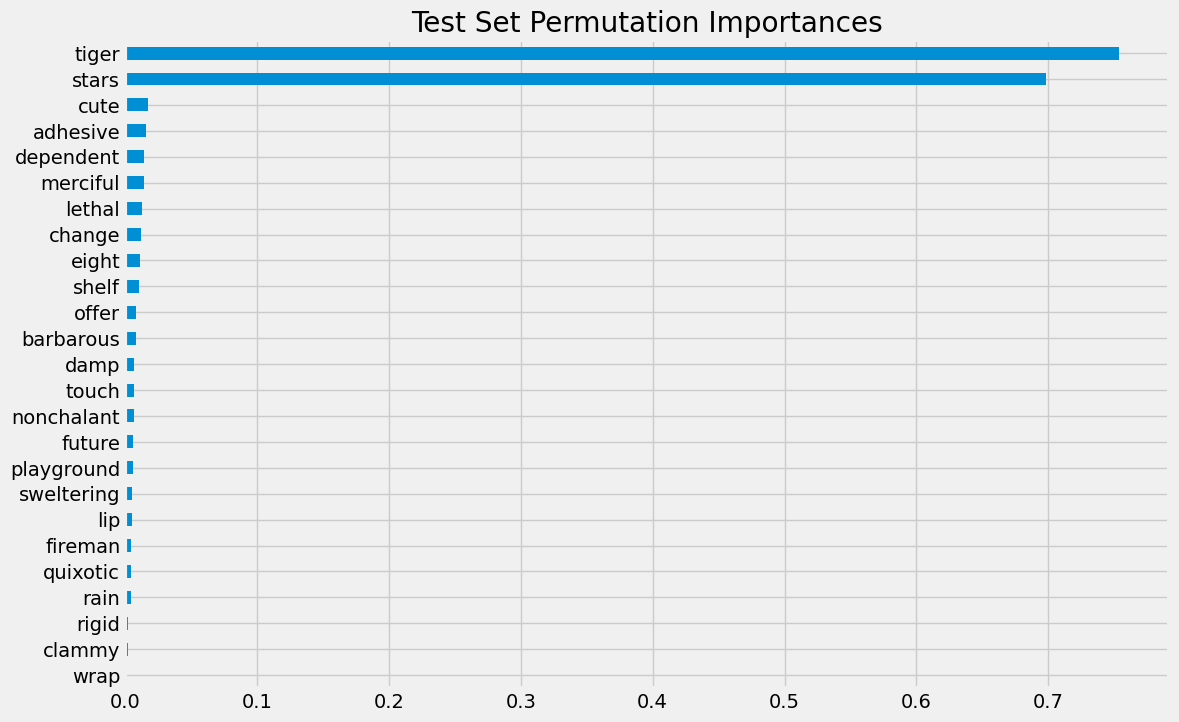

In [45]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [46]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': array([[ 0.03969235,  0.05497264,  0.0093906 , ...,  0.00596039,
          0.00331973, -0.00331128],
        [-0.04213146,  0.08599225, -0.01079385, ..., -0.01067093,
          0.01386028,  0.02319617],
        [-0.14177495, -0.08901163,  0.00701576, ...,  0.02431059,
          0.011366  , -0.00195435],
        ...,
        [-0.15865637, -0.18071269,  0.00405485, ...,  0.01730419,
          0.00584577, -0.00102946],
        [ 0.12225503, -0.29827456,  0.00759716, ...,  0.00263112,
          0.0118409 ,  0.01002479],
        [ 0.00064609,  0.17975354, -0.02651579, ..., -0.00605966,
          0.00717092, -0.00214051]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

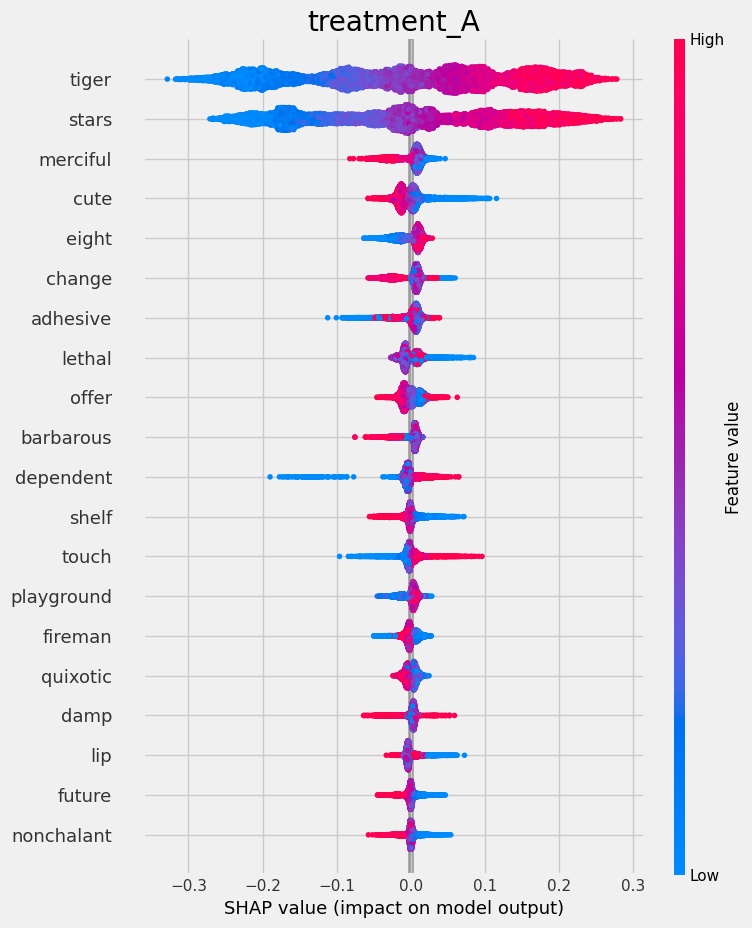

In [47]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

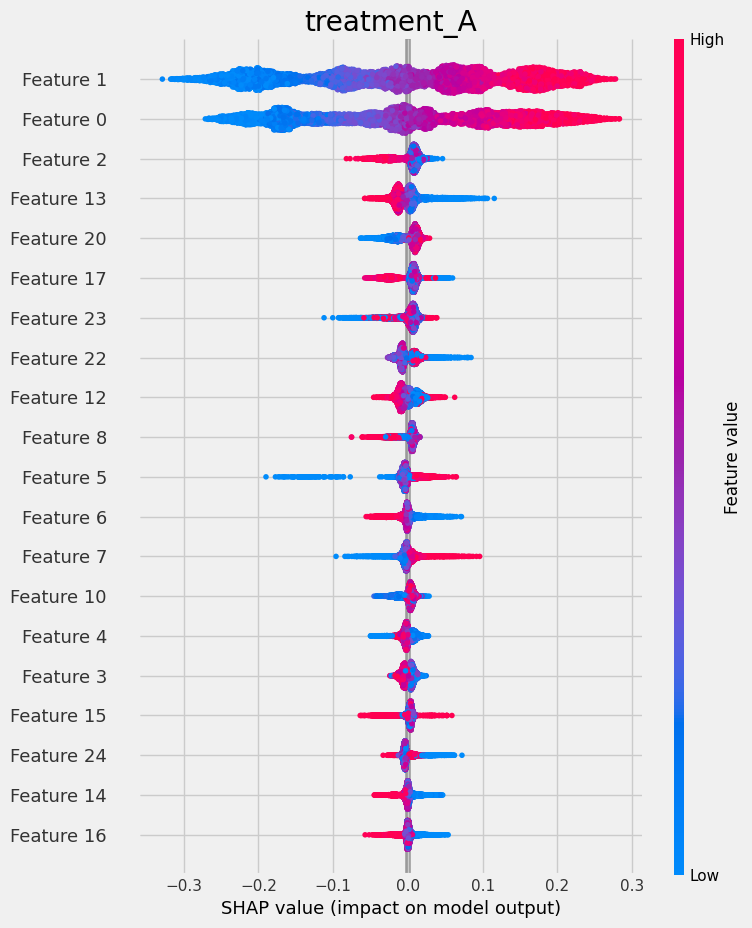

In [48]:
# shap_dict specified
xlearner.plot_shap_values(X=X, shap_dict=shap_xlearner)

## R Learner

In [49]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, w_multi, y, p=e_multi)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 25
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Start training from score 1.504518
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

### Feature Importance (method = `auto`)

In [50]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': tiger         0.217448
 stars         0.190234
 barbarous     0.040347
 shelf         0.038681
 offer         0.035831
 dependent     0.033259
 touch         0.032651
 wrap          0.031003
 nonchalant    0.030521
 lethal        0.026432
 change        0.026164
 merciful      0.025518
 adhesive      0.025285
 sweltering    0.024848
 cute          0.024462
 damp          0.024127
 future        0.023410
 lip           0.022143
 rigid         0.022100
 eight         0.021466
 fireman       0.021404
 quixotic      0.017534
 rain          0.017429
 clammy        0.014095
 playground    0.013611
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

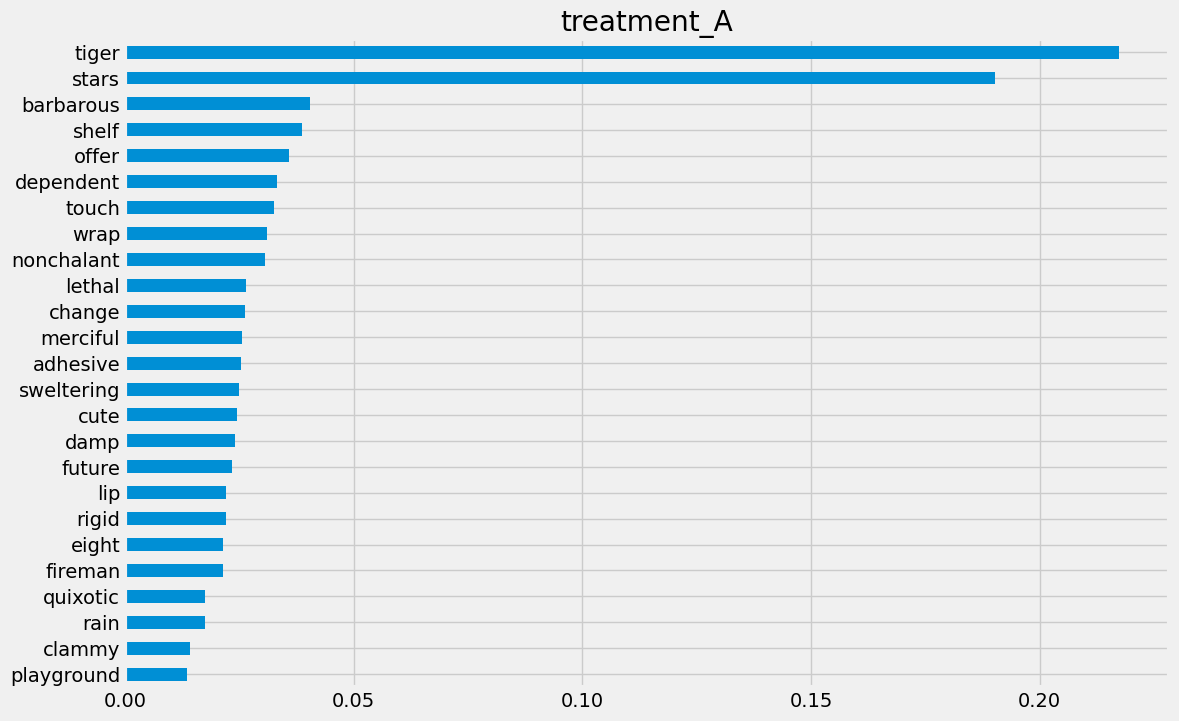

In [51]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [52]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': tiger         0.307040
 stars         0.240590
 barbarous     0.033435
 dependent     0.027522
 offer         0.026702
 shelf         0.022277
 nonchalant    0.019459
 wrap          0.019423
 change        0.015561
 lip           0.015376
 cute          0.014645
 lethal        0.014471
 touch         0.014162
 rigid         0.013726
 adhesive      0.013344
 sweltering    0.013331
 eight         0.012763
 damp          0.012506
 fireman       0.011978
 merciful      0.009834
 playground    0.007059
 future        0.005506
 clammy        0.005450
 quixotic      0.005254
 rain          0.004343
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

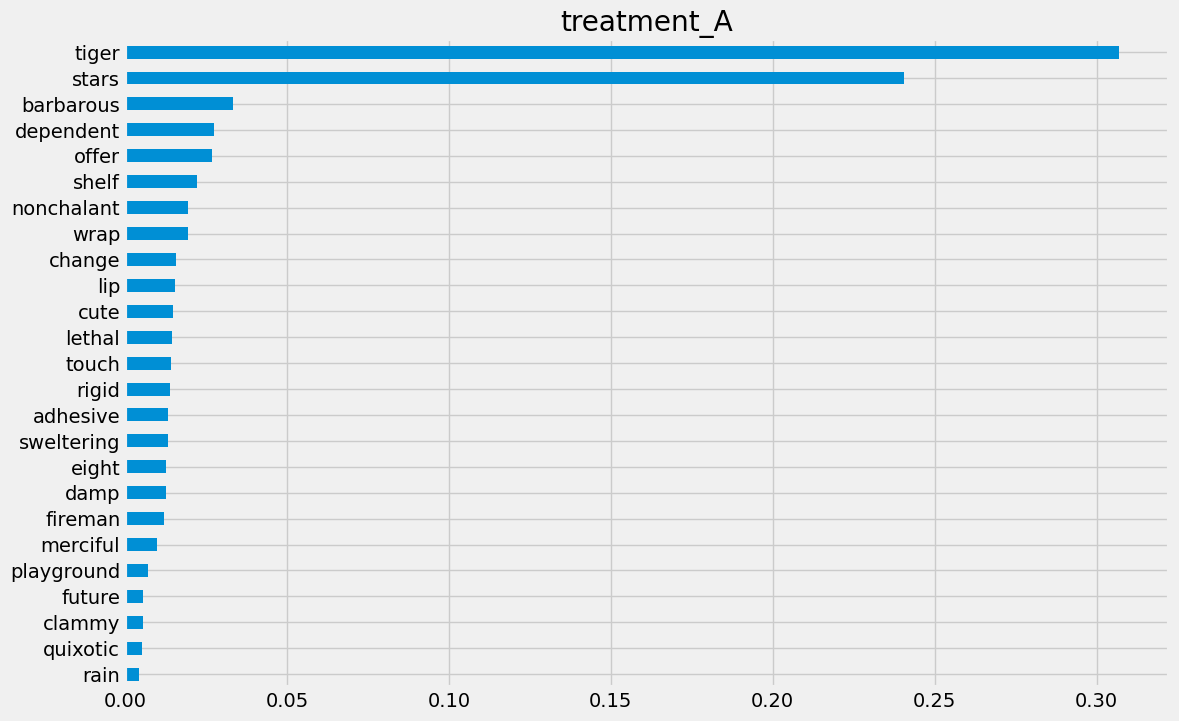

In [53]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [54]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 25
[LightGBM] [Info] Start training from score 0.510613
Elapsed time: 6.277476787567139 seconds


In [55]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.307040
stars         0.240590
barbarous     0.033435
dependent     0.027522
offer         0.026702
shelf         0.022277
nonchalant    0.019459
wrap          0.019423
change        0.015561
lip           0.015376
cute          0.014645
lethal        0.014471
touch         0.014162
rigid         0.013726
adhesive      0.013344
sweltering    0.013331
eight         0.012763
damp          0.012506
fireman       0.011978
merciful      0.009834
playground    0.007059
future        0.005506
clammy        0.005450
quixotic      0.005254
rain          0.004343
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

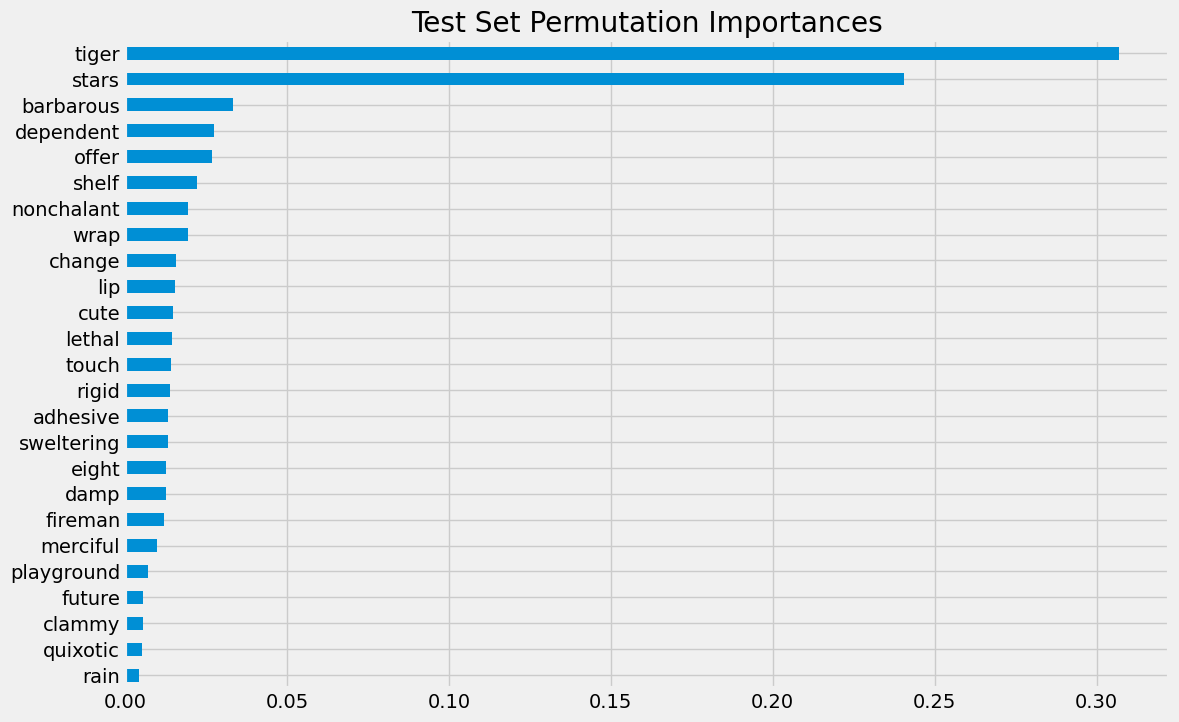

In [56]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [57]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment_A': array([[ 0.00947901,  0.02653088, -0.00643296, ...,  0.00050373,
          0.01416255, -0.00761714],
        [-0.04657098,  0.04224252, -0.00833537, ..., -0.0283912 ,
          0.00808825,  0.04318957],
        [-0.14476858, -0.06571072,  0.00502764, ...,  0.04105416,
         -0.00231606,  0.01115761],
        ...,
        [-0.18599577, -0.17795777,  0.01116026, ...,  0.03024388,
          0.00310726, -0.00427537],
        [ 0.06890251, -0.26149964,  0.01529999, ...,  0.00141899,
         -0.00144109,  0.01920935],
        [ 0.03012914,  0.21654837, -0.06279933, ..., -0.01098327,
          0.00515799, -0.01031136]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

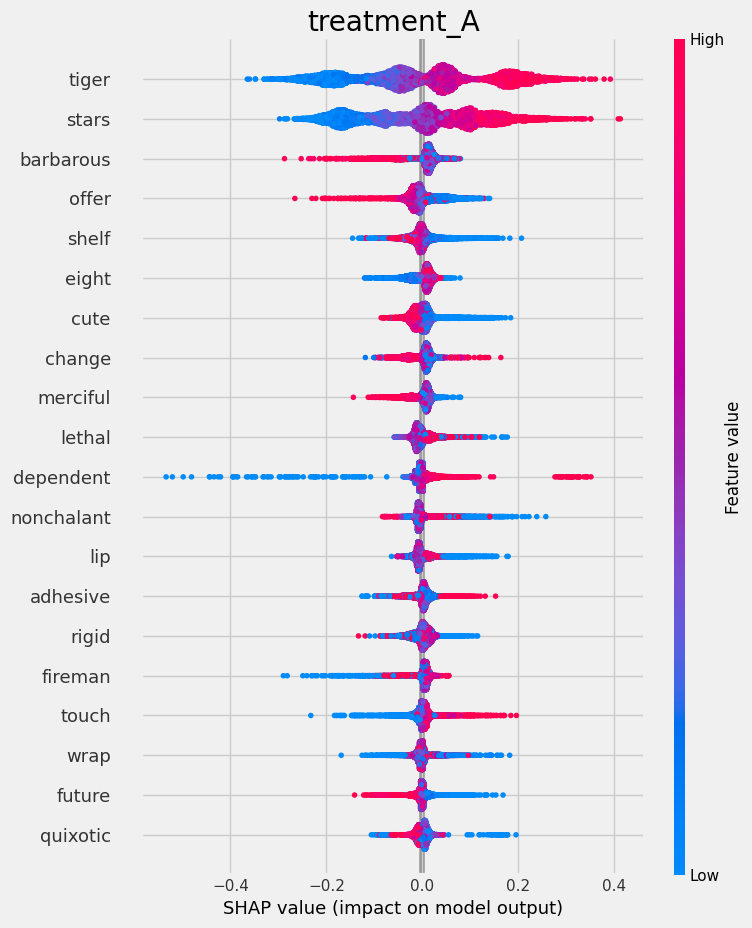

In [58]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

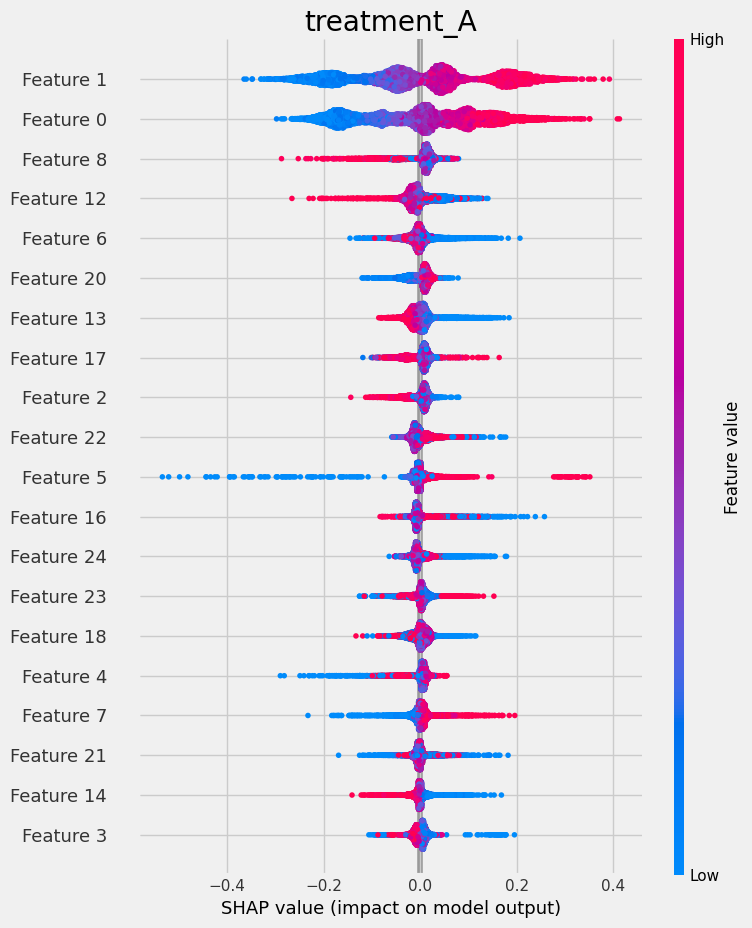

In [59]:
# with providing shap_dict
rlearner.plot_shap_values(X=X, shap_dict=shap_rlearner)

# Uplift Tree/Forest

Note that uplift trees/forests are only implemented for classification at the moment, hence the following section uses a different synthetic data generation process.

### UpliftTreeClassifier

In [60]:
from causalml.dataset import make_uplift_classification

df, x_names = make_uplift_classification()

In [61]:
uplift_tree = UpliftTreeClassifier(control_name='control')

uplift_tree.fit(X=df[x_names].values,
                treatment=df['treatment_group_key'].values,
                y=df['conversion'].values)

<AxesSubplot:>

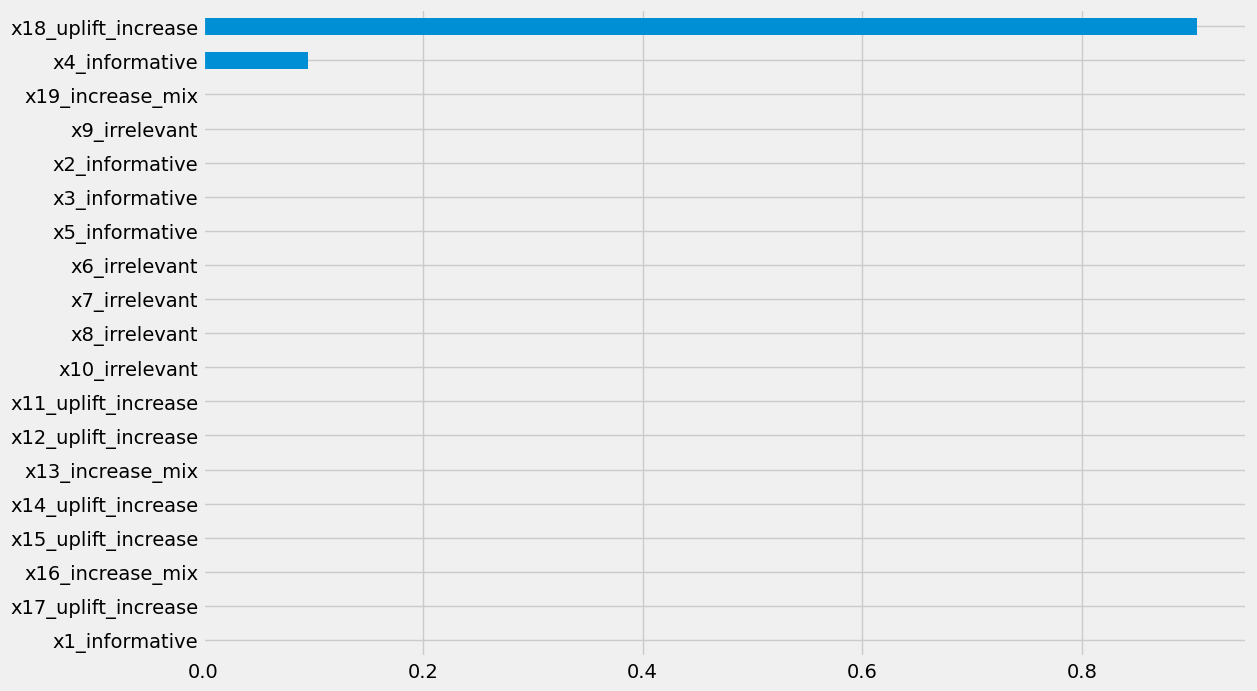

In [62]:
pd.Series(uplift_tree.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))

### UpliftRandomForestClassifier

In [63]:
uplift_rf = UpliftRandomForestClassifier(control_name='control')

uplift_rf.fit(X=df[x_names].values,
              treatment=df['treatment_group_key'].values,
              y=df['conversion'].values)

<AxesSubplot:>

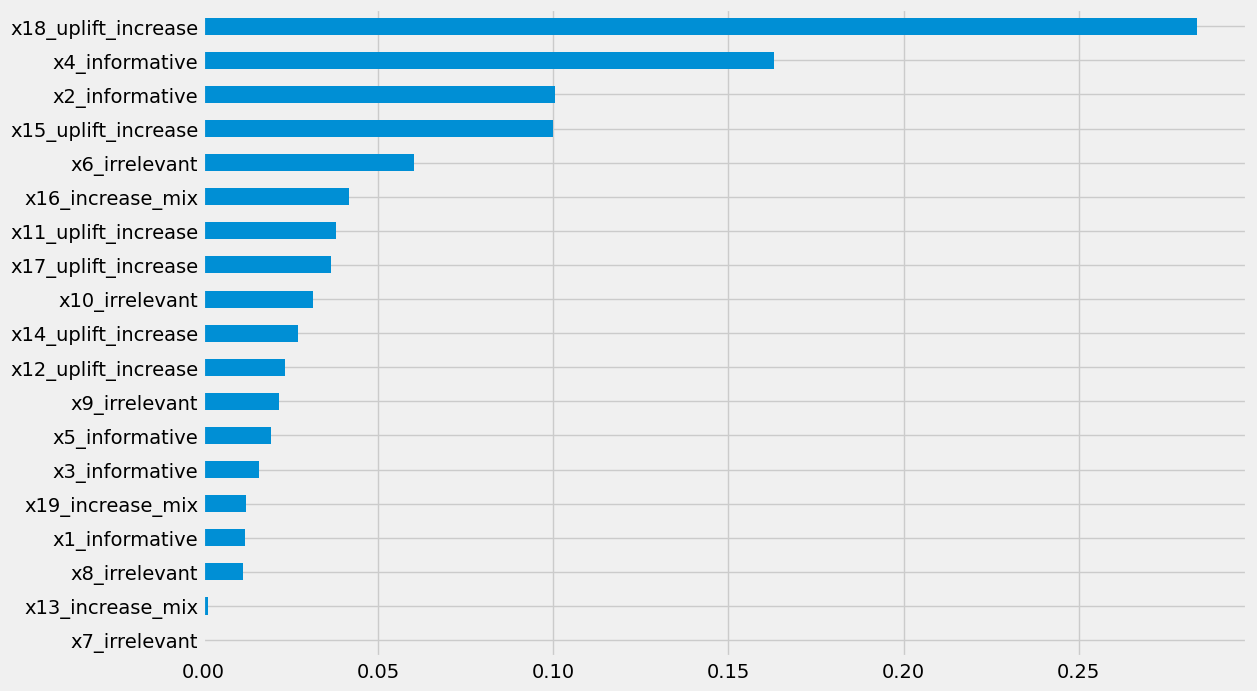

In [64]:
pd.Series(uplift_rf.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))